In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'flickr8k:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F623289%2F1111676%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240625%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240625T062939Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1d990e5378732556b6dd482d36665c9442364f71ca6858afaabb1f35ba90ea23c991db105f8a3690555f411cfd3f23a58e35b0be8f3b17aa343bc34623e504ea31a5783f17ff4794cef3e088a50b4993613aa84314b75089ae400724e0421ff7a89ce2db12fbfe2cb5292dd9f8fe7d12a94e21c2953e6b71f1c283a331d0aa65f518a6001feb6e190651bf08df082b86128da778e3a23b24098e7e9e59c6bafe37936b4832c5364476ae2b76bd2aaea24aa1770e5790c91d582b93fd7988a930dd0854fbd83cc3b3d9432d086b0c601e2ef0fd0a303bcb10e1ef59360352453a2ce6df0ec6205aacfa9c40bc44c3d237099169f9e7c0a23eabda73ac4fa2e22f'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1112971163 bytes downloaded
Downloaded and uncompressed: flickr8k
Data source import complete.


In [2]:

import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


Streaming output truncated to the last 5000 lines.
/kaggle/input/flickr8k/Images/2276314067_7ee246f859.jpg
/kaggle/input/flickr8k/Images/3097171315_0ba7d283b1.jpg
/kaggle/input/flickr8k/Images/3296150666_aae2f64348.jpg
/kaggle/input/flickr8k/Images/2963573792_dd51b5fbfb.jpg
/kaggle/input/flickr8k/Images/3523819210_99782628fc.jpg
/kaggle/input/flickr8k/Images/3461437556_cc5e97f3ac.jpg
/kaggle/input/flickr8k/Images/2789937754_5d1fa62e95.jpg
/kaggle/input/flickr8k/Images/3624676866_8f6d0efcc9.jpg
/kaggle/input/flickr8k/Images/3565655045_8eb00b7423.jpg
/kaggle/input/flickr8k/Images/2812125355_5e11a76533.jpg
/kaggle/input/flickr8k/Images/3110018626_307a123b59.jpg
/kaggle/input/flickr8k/Images/2258662398_2797d0eca8.jpg
/kaggle/input/flickr8k/Images/2875583266_4da13ae12d.jpg
/kaggle/input/flickr8k/Images/3124838157_7ef96745b7.jpg
/kaggle/input/flickr8k/Images/2335619125_2e2034f2c3.jpg
/kaggle/input/flickr8k/Images/3662963630_8f097e38d4.jpg
/kaggle/input/flickr8k/Images/3640329164_20cb245fd5.j

In [3]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [4]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

In [5]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

553467096/553467096 [==============================] - 25s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [6]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [8]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [9]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)


In [11]:
#load caption data
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()


In [12]:
#splitting and appending the caption data with the image
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)
    len(mapping)


  0%|          | 0/40456 [00:00<?, ?it/s]

**PreProcessing Data**

In [19]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
        # take one caption at a time
          caption = captions[i]
        # preprocessing steps
        # convert to lowercase
          caption = caption.lower()
        # delete digits, special chars, etc.,
          caption = caption.replace('[^A-Za-z]', '')
        # delete additional spaces
          caption = caption.replace('\s+', ' ')
        # add start and end tags to the caption
          caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
          captions[i] = caption

In [20]:
# before preprocess of text
mapping['1000268201_693b08cb0e']


['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [22]:
clean(mapping)

In [23]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [25]:
#storing the preprocessed captions in a list
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)
len(all_captions)
#viewing the first 10 captions
all_captions[:10]


['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [26]:
#processing the text data
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
vocab_size
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

**Splitting for Testing and Training**


In [27]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]


In [28]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], 	num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

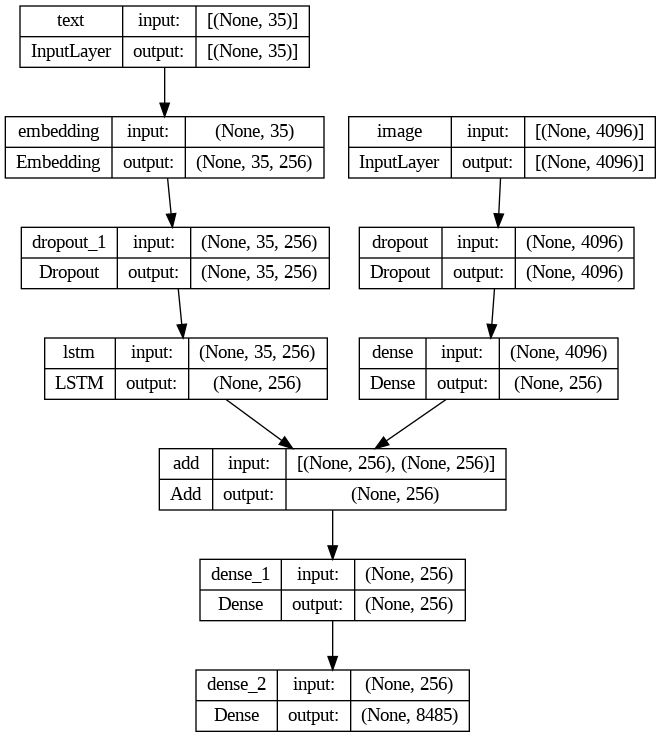

In [29]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

Training the model

In [30]:
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 56s 247ms/step - loss: 2.1868


In [31]:
model.save(WORKING_DIR+'/latest_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Generating caption for the images

In [32]:
#converting the predicted index into word
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
          return word
    return None

In [33]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

Validation

In [36]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    # calculating BLEU score
    print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.642857
BLEU-2: 0.497245
BLEU-1: 0.636364
BLEU-2: 0.471940
BLEU-1: 0.558824
BLEU-2: 0.355227
BLEU-1: 0.500000
BLEU-2: 0.282038
BLEU-1: 0.508475
BLEU-2: 0.274462
BLEU-1: 0.485714
BLEU-2: 0.246403
BLEU-1: 0.483146
BLEU-2: 0.254583
BLEU-1: 0.484211
BLEU-2: 0.258433
BLEU-1: 0.471154
BLEU-2: 0.253917
BLEU-1: 0.504425
BLEU-2: 0.279924
BLEU-1: 0.508197
BLEU-2: 0.287072
BLEU-1: 0.511278
BLEU-2: 0.283343
BLEU-1: 0.514286
BLEU-2: 0.277381
BLEU-1: 0.496689
BLEU-2: 0.262457
BLEU-1: 0.503106
BLEU-2: 0.262523
BLEU-1: 0.491429
BLEU-2: 0.248626
BLEU-1: 0.510870
BLEU-2: 0.259423
BLEU-1: 0.512821
BLEU-2: 0.269132
BLEU-1: 0.490476
BLEU-2: 0.253374
BLEU-1: 0.493274
BLEU-2: 0.256140
BLEU-1: 0.493613
BLEU-2: 0.254188
BLEU-1: 0.490040
BLEU-2: 0.249113
BLEU-1: 0.505703
BLEU-2: 0.267659
BLEU-1: 0.512915
BLEU-2: 0.277188
BLEU-1: 0.512367
BLEU-2: 0.274709
BLEU-1: 0.520690
BLEU-2: 0.280878
BLEU-1: 0.518519
BLEU-2: 0.277160
BLEU-1: 0.511401
BLEU-2: 0.270775
BLEU-1: 0.517460
BLEU-2: 0.272363
BLEU-1: 0.5243

Result visualization

In [37]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq man in sunglasses and neatly trimmed beard overlooks woody valley endseq
startseq man posing with large grassy mountains off in the distance endseq
startseq man wearing sunglasses stands before forested landscape endseq
startseq man with beard and sunglasses is standing in front of tree-covered hills endseq
startseq bearded man with sunglasses in the mountains endseq
--------------------Predicted--------------------
startseq man in sunglasses and neatly trimmed beard is standing on the side of the side of the woods endseq


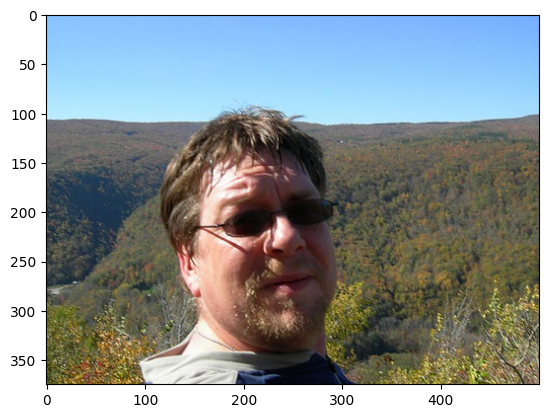

In [41]:
generate_caption("265528702_8653eab9fa.jpg")


In [42]:
#testing with real image
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)


Testing for the image:

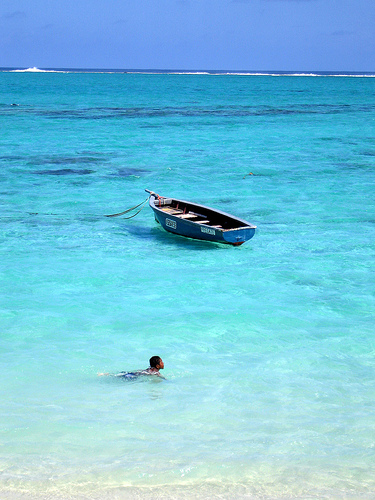


In [48]:
image_path = '/kaggle/input/flickr8k/Images/309430053_cc58bcc36a.jpg'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)


'startseq the man is swimming in the ocean with his boat in the water endseq'